# `FyTok` Quick Start


## 介绍

`FyTok` 用于执行集成工作流。 

In [16]:
import pathlib
import scipy.constants
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from fytok.Tokamak import Tokamak
from fytok.modules.CoreProfiles import CoreProfiles
from fytok.modules.Equilibrium import Equilibrium
from spdm.view import View as sp_view
from spdm.core.Path import Path
from spdm.core.Function import Function


## 导入基准数据 （ITER 15MA）

In [17]:
core_profiles_astra = CoreProfiles(f"file+iterprofiles://./data/15MA Inductive at burn-ASTRA.xls#core_profiles")

core_profiles_1d_astra = core_profiles_astra.time_slice.current.profiles_1d

equilibrium_astra = Equilibrium(f"file+geqdsk://./data/g900003.00230_ITER_15MA_eqdsk16VVHR.txt#equilibrium")

2024-04-23 12:55:55,102 [    spdm]     INFO: Initialize module fytok.modules.CoreProfiles 
2024-04-23 12:55:55,202 [    spdm]     INFO: Initialize module fytok.plugins.equilibrium.FyEqAnalyze 


## 创建 Tokamak 实例

初始化信息包括

| 参数                               | 解释                                                                                                                                                                                                |
| ---------------------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| "f""                | 数据源。指向一个 geqdsk 文件(file+geqdsk://...)，提供平衡信息,或者数据源的entry入口                                                                                                                                                          |
| device="name"                      | 指定装置名称。根据装置名称，可以自动调取装置的静态信息，例如，wall.limiter 的几何形状，pf_active.coils 极向场线圈的位置等等。默认支持的装置信息，括 EAST、ITER 和 D3D，可通过配置文件扩展其他装置。 |
| shot=900003 ，                     | 指定放电的炮号。若数据源包含实验数据库，会自动读取相应的炮号作为数据。                                                                                                                              |
| run=0                              | 指定模拟运行的编号。若数据源中包含可写入的是模拟数据库，写入模拟结果是会作为数据 index 的一部分。                                                                                                   |
| equilibrium={"code.name: "fy_eq" } | 指定子模块 equilibrium 的初始化信息。其中 code.name="fy_eq"，意为调用路径 `fytok.modules.equilibrium.fy_eq` 下的插件                                                                                |
| transport_solver={"code.name: "fy_trans" } | 指定子模块 transport_solver 的初始化信息。其中 code.name="fy_trans"，意为调用路径 `fytok.modules.equilibrium.fy_trans` 下的插件                                                                                |
| core_sources={"code.name: "genray" } | 指定子模块 core_sources 的初始化信息。其中 code.name="genray"，意为调用第三方物理模块genray                                                                                |
| core_transport="model": [ {"code": {"name": "dummy"}},,] | 指定子模块 core_transport 的初始化信息。其中 code.name意在调用计算输运系数的模块                                                                              |
| ...... | ......   |



## 初始化 Tokamak 实例



In [18]:
tokamak = Tokamak(
    device="iter",
    shot=900003,
    equilibrium=f"file+geqdsk://./data/g900003.00230_ITER_15MA_eqdsk16VVHR.txt#equilibrium",
    core_transport={
        "model": [
            {"code": {"name": "predefined"}},
            {"code": {"name": "fast_alpha"}},
        ]
    },
    core_sources={
        "source": [
            f"file+iterprofiles://./data/15MA Inductive at burn-ASTRA.xls#core_sources/source/0",
            {"code": {"name": "collisional_equipartition"}},
            {"code": {"name": "fusion", "parameters": {"fusion_reactions": ["D(t,n)alpha"], "heating": True}}},
            # {"code": {"name": "radiation"}},
            # {"code": {"name": "synchrotron_radiation"}},
        ]
    },
    transport_solver={
        "code": {
            "name": "fy_trans",
            "parameters": {
                "discontinuity": [0.96, 0.995],
                "dc_pos": 0.96,
                "hyper_diff": 1.0e-5,
                "max_nodes": 512,
                "bc_tol": 1,
                "verbose": 2,
                "units": {
                    "psi_norm": 1,
                    "psi_norm_flux": -0.1,
                    "*/density": 1.0e19,
                    "*/density_flux": 1.0e23,
                    "*/temperature": 1.0e4,
                    "*/temperature_flux": 1.0e26,
                    # "ion/alpha/density": 1.0e14,
                    # "ion/alpha/density_flux": 1.0e16,
                    # "ion/He/density": 1.0e15,
                    # "ion/He/density_flux": 1.0e15,
                },
            },
        },
        "ion_thermal": ["D", "T"],  #
        "ion_non_thermal": ["alpha", "He"],
        "impurities": ["Ar", "Be"],
        "boundary_condition_type": {
            # fmt: off
            # psi                          at axis \frac{d\psi}{dx}=0  , at boundary \psi=?
            "psi"                       : 1, 
            "psi_norm"                  : 1, 
            # density                      at axis \Gamma_s=0          , at boundary n=?
            "*/density"                 : 1, 
            # temperatur                   at axis \frac{dT}{dx}=0     , at boundary T=?
            "*/temperature"             : 1,
            # fmt: on
        },
    },
)

## 展示概要信息

展示模拟的概要信息，包括 
- 装置名称、炮号、运行序号，
- 使用者、运行环境、运行时间、采用的 Ontology 版本
- 调用的模块信心

In [19]:
print(tokamak.brief_summary)

2024-04-23 12:55:55,241 [    spdm]     INFO: Initialize module fytok.modules.DatasetFAIR 
2024-04-23 12:55:55,244 [    spdm]     INFO: Initialize module fytok.plugins.transport_solver_numerics.fy_trans 
2024-04-23 12:55:55,300 [    spdm]     INFO: Initialize module fytok.plugins.equilibrium.FyEqAnalyze 
2024-04-23 12:55:55,305 [    spdm]     INFO: Initialize module fytok.modules.CoreTransport 
2024-04-23 12:55:55,308 [    spdm]     INFO: Initialize module fytok.plugins.core_transport.model.predefined 
2024-04-23 12:55:55,311 [    spdm]     INFO: Initialize module fytok.plugins.core_transport.model.fast_alpha 
2024-04-23 12:55:55,316 [    spdm]     INFO: Initialize module fytok.modules.CoreSources 
2024-04-23 12:55:55,380 [    spdm]     INFO: Initialize module fytok.plugins.core_sources.source.dummy 
2024-04-23 12:55:55,382 [    spdm]     INFO: Initialize module fytok.plugins.core_sources.source.collisional_equipartition 
2024-04-23 12:55:55,386 [    spdm]     INFO: Initialize module fy

## 可视化
### 适用于 JupyterLab 环境的可视化接口
FyTok 提供了适用于 JupyterLab 环境的可视化接口，`spdm.view.View.display()`调用。默认情况下，`Tokamak` 会将能够获取到的信息尽可能绘制到一张图上。如下图，展示了 pf_active 极向场线圈、magnetic 磁场探针，wall.limiter 壁, interferometer 干涉仪的几何信息，磁平衡信息给出了二维磁面的等高线，最外层磁面、磁轴、X-point等信息。

```{note} 
具有 IDS 可视化语义的 IDS 都应支持 `spdm.view.View.display()` 可视化，如 wall,pf_active,equilibrium。关于可视化库 spdm.view 的进一步细节请参考第二部分 SpDM 的可视化章节。
```

2024-04-23 12:55:55,423 [    spdm]     INFO: Initialize module fytok.modules.Wall 
2024-04-23 12:55:55,886 [    spdm]     INFO: Initialize module fytok.modules.PFActive 
2024-04-23 12:55:55,909 [    spdm]     INFO: Initialize module fytok.modules.Magnetics 
2024-04-23 12:55:56,060 [    spdm]     INFO: Initialize module fytok.modules.Interferometer 
2024-04-23 12:55:56,063 [    spdm]     INFO: Initialize module fytok.modules.TF 


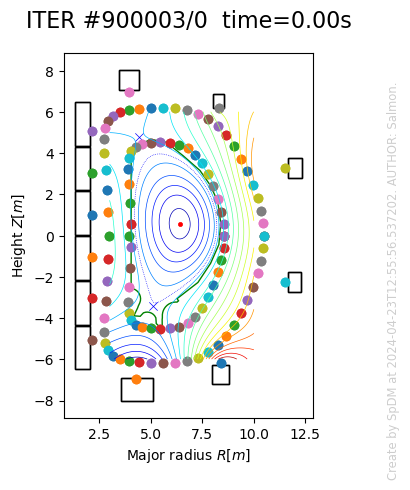

In [20]:
from spdm.view import View as sp_view
fig=sp_view.display(tokamak)

## 将可视化结果输出为图像文件

通过指定输出文件路径 `output=f"output/{tok.tag}_rz.svg"`，可以将可视化结果以文件的形式保存。

In [21]:
sp_view.display(tokamak, title=tokamak.title, output=f"output/{tokamak.tag}_rz.svg")

2024-04-23 12:55:58,617 [    spdm]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/view/view_matplotlib.py:92:_figure_post: Write figure to  output/iter_900003_0_000000_rz.svg


输出的文件如下

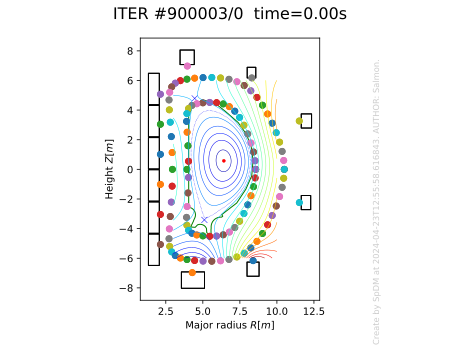

In [22]:
from IPython.core.display import SVG
SVG(f"output/{tokamak.tag}_rz.svg")

In [23]:
tokamak.initialize()

2024-04-23 12:55:59,696 [    spdm]     INFO: Initialize module fytok.modules.CoreProfiles 


In [24]:
tokamak.refresh()

2024-04-23 12:55:59,864 [    spdm]     INFO: Refresh module fytok.modules.CoreProfiles
2024-04-23 12:56:00,802 [    spdm]    ERROR: /home/salmon/workspace/fytok/python/fytok/plugins/equilibrium/fy_eq/fy_eq.py:234:find_surfaces_by_psi: Can not find surf at -1.1189676199999994  
NoneType: None
2024-04-23 12:56:01,190 [    spdm]     INFO: Refresh module fytok.plugins.equilibrium.FyEqAnalyze
2024-04-23 12:56:01,191 [    spdm]     INFO: Refresh module fytok.modules.CoreSources
2024-04-23 12:56:01,192 [    spdm]     INFO: Refresh module fytok.plugins.core_sources.source.dummy
2024-04-23 12:56:01,195 [    spdm]     INFO: Refresh module fytok.plugins.core_sources.source.collisional_equipartition
2024-04-23 12:56:01,199 [    spdm]     INFO: Refresh module fytok.plugins.core_sources.source.fusion
2024-04-23 12:56:01,203 [    spdm]     INFO: Refresh module fytok.modules.CoreTransport
2024-04-23 12:56:01,204 [    spdm]     INFO: Refresh module fytok.plugins.core_transport.model.predefined
2024-04-

In [25]:
rho_tor_norm_bdry=0.995
rho_tor_norm = np.linspace(0.001,rho_tor_norm_bdry, 128)
eq_grid = tokamak.equilibrium.time_slice.current.profiles_1d.grid.remesh(rho_tor_norm)
psi_norm = eq_grid.psi_norm
F = (1 - rho_tor_norm**2) ** 2
n =3e19 -tokamak.core_sources.source[0].fetch(core_profiles_1d_astra).profiles_1d.ion["D"].particles.I(rho_tor_norm)


In [27]:
solver_1d = tokamak.solve(

    rho_tor_norm=rho_tor_norm,
    impurity_fraction=0.02 * 4 + 0.0012 * 18,
    # fmt:off
    initial_value={
        "psi":                              0.0,
        "psi_norm":                         psi_norm,
        "ion/D/density":                    n,          # 5.0e19*Fn , #core_profiles_1d_astra.ion["D"].density(rho_tor_norm) ,# 1.0e19,  #
        "ion/T/density":                    n,          # 5.0e19*Fn , #core_profiles_1d_astra.ion["T"].density(rho_tor_norm) ,# 1.0e19,  #
        "ion/He/density":                   2.0e19*F,   # core_profiles_1d_astra.ion["He"].density(rho_tor_norm)   ,#    
        "ion/alpha/density":                1.0e18*F,   #core_profiles_1d_astra.ion["alpha"].density(rho_tor_norm) ,# 
        
        "ion/D/temperature":                3.5e4*F, # core_profiles_1d_astra.ion["D"].temperature(rho_tor_norm) *0.5,# 
        "ion/T/temperature":                3.5e4*F, # core_profiles_1d_astra.ion["T"].temperature(rho_tor_norm) *0.5,# 
        "electrons/temperature":            3.5e4*F, #core_profiles_1d_astra.electrons.temperature(rho_tor_norm),# 
    },
    # boundary_value={
    #     "ion/D/density":                    n[-1],   # core_profiles_1d_astra.ion["D"].density (rho_tor_norm[-1])    ,
    #     "ion/T/density":                    n[-1],   # core_profiles_1d_astra.ion["T"].density (rho_tor_norm[-1])    ,
    #     "ion/He/density":                   1.0e19*F[-1],
    #     "ion/alpha/density":                1.0e18*F[-1],
    #     "ion/D/temperature":                4.0e4*F[-1] , # core_profiles_1d_astra.ion["D"].temperature (rho_tor_norm[-1]) ,  # 2000,
    #     "ion/T/temperature":                4.0e4*F[-1] , # core_profiles_1d_astra.ion["T"].temperature (rho_tor_norm[-1]) ,  # 2000,
    #     "electrons/temperature":            4.0e4*F[-1] , # core_profiles_1d_astra.electrons.temperature(rho_tor_norm[-1]),   # 2000,
    # },
    # fmt:on
)

2024-04-23 12:56:21,077 [    spdm]     INFO: Refresh module fytok.plugins.transport_solver_numerics.fy_trans
2024-04-23 12:56:24,180 [    spdm]     INFO: Solve transport equations : psi_norm  ,electrons/temperature  ,ion/T/density  ,ion/T/temperature  ,ion/D/density  ,ion/D/temperature  ,ion/alpha/density  ,ion/He/density
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          4.60e-01       3.36e-16          128            28       
       2          5.44e-03       3.36e-16          156            15       
       3          9.68e-04       3.36e-16          171             0       
Solved in 3 iterations, number of nodes 171. 
Maximum relative residual: 9.68e-04 
Maximum boundary residual: 3.36e-16
2024-04-23 12:56:27,435 [    spdm]     INFO: Solving the transport equation [success]: The algorithm converged to the desired accuracy. , 3 iterations


## 后处理


In [28]:
tokamak.flush()
core_profiles_1d = tokamak.core_profiles.time_slice.current.profiles_1d

2024-04-23 12:56:35,564 [    spdm]    ERROR: /home/salmon/workspace/fytok/python/fytok/plugins/equilibrium/fy_eq/fy_eq.py:234:find_surfaces_by_psi: Can not find surf at -1.1189676199999994  
NoneType: None


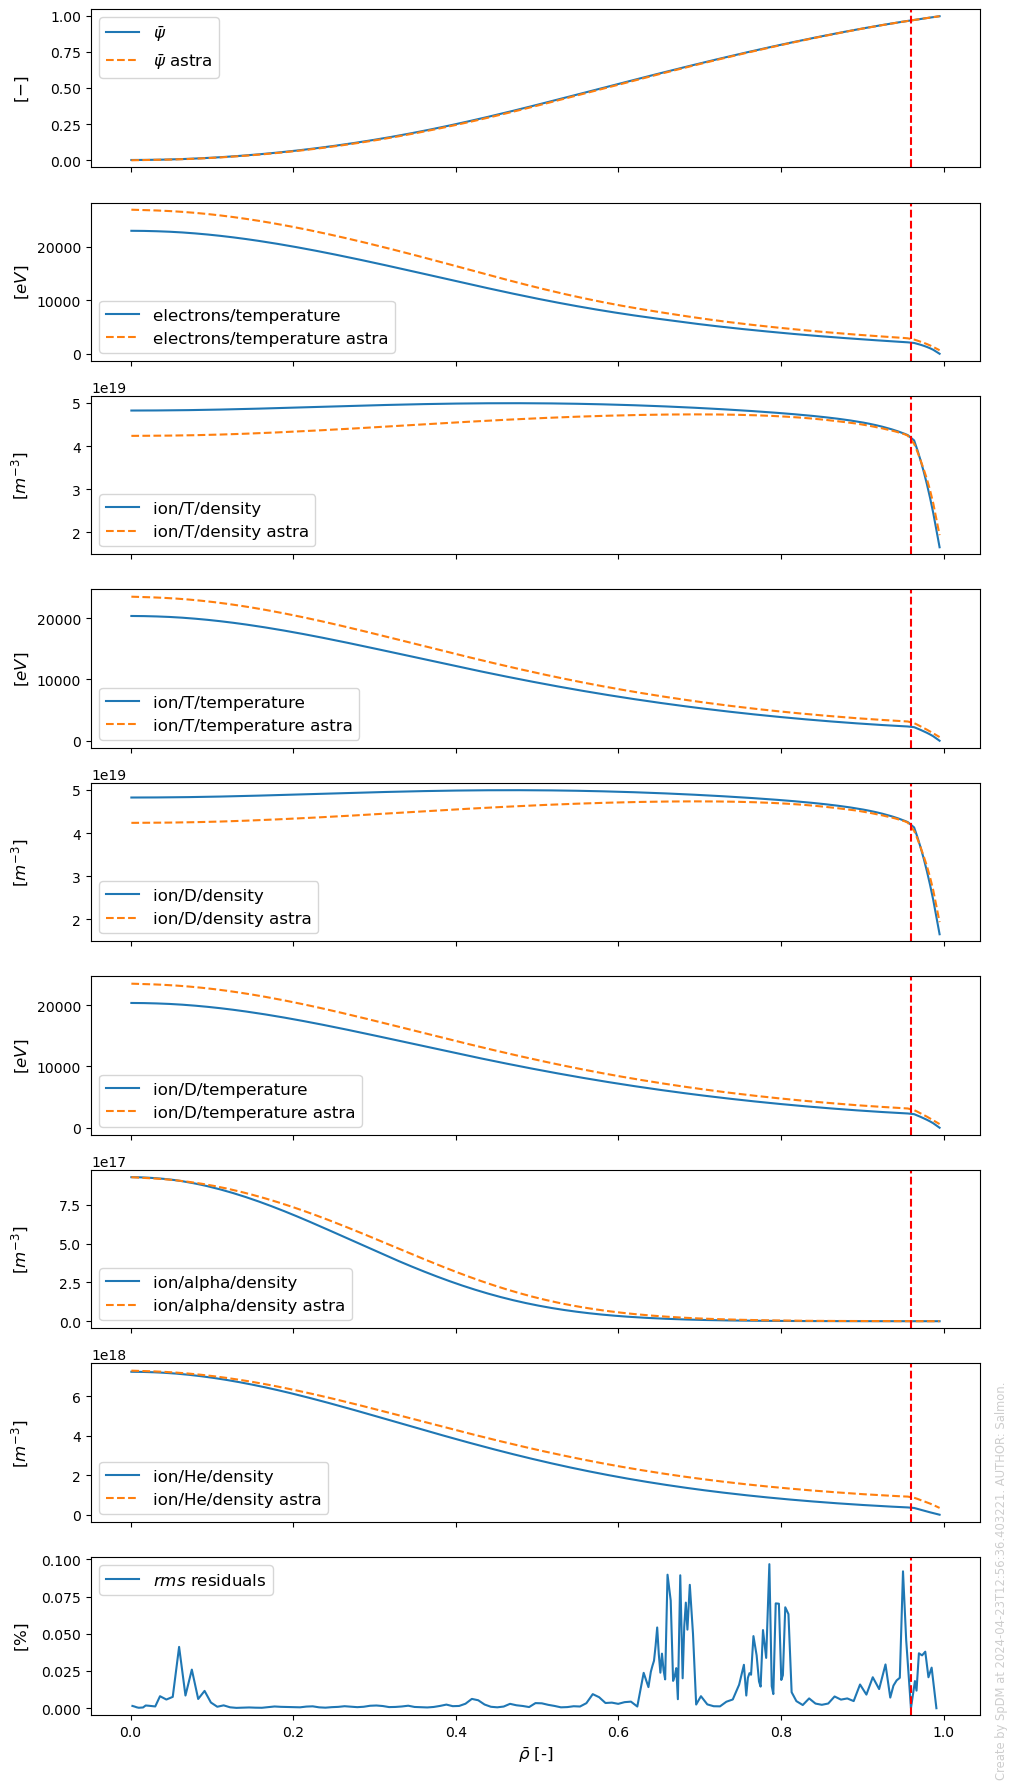

In [29]:
fig = sp_view.plot(
    solver_1d.grid.rho_tor_norm,
    [
        (core_profiles_1d.psi_norm, r"$\bar{\psi}$"),
        (
            Function(
                equilibrium_astra.time_slice.current.profiles_1d.grid.rho_tor_norm[:-1],
                equilibrium_astra.time_slice.current.profiles_1d.grid.psi_norm[:-1],
            ),
            {"label": r"$\bar{\psi}$ astra", "$matplotlib": {"linestyle": "dashed"}},
        ),
    ],
    *[
        [
            (Path(equ.identifier).get(core_profiles_1d, 0), f"{equ.identifier} "),
            (
                Path(equ.identifier).get(core_profiles_1d_astra, 0),
                {"label": f"{equ.identifier} astra", "$matplotlib": {"linestyle": "dashed"}},
            ),
        ]
        for equ in solver_1d.equations
        if equ.identifier != "psi_norm"
    ],
    (
        (0.5 * (solver_1d.X[:-1] + solver_1d.X[1:]), solver_1d.rms_residuals * 100),
        {"label": "$rms$ residuals", "y_label": r"[\%]"},
    ),
    vline={"x": 0.96, "color": "r", "linestyle": "--"},
    x_label=r"$\bar{\rho}$ [-]",
    fontsize=12,
)